# Compare spex with desi_extract_spectra

This was run at jupyter.nersc.gov on a cori shared cpu node with the DESI master kernel.

Generate sample extraction files for comparison on NERSC:

```
#- Setup environement
source /global/cfs/cdirs/desi/software/desi_environment.sh master
cd gpu_specter
export PATH=$(pwd)/bin:$PATH
export PYTHONPATH=$(pwd)/py:$PYTHONPATH

#- Get an interactive node
salloc -N 1 -C haswell -t 60 -q interactive
basedir=/global/cfs/cdirs/desi/spectro/redux/daily/

#- spex
time srun -n 32 -c 2 spex --mpi -w 6000.0,6399.2,0.8 \
    -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits \
    -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits \
    -o $SCRATCH/spex.fits

#- desi_extract_spectra
time srun -n 32 -c 2 desi_extract_spectra --mpi -w 6000.0,6399.2,0.8 \
    -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits \
    -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits \
    -o $SCRATCH/desi_extract.fits
    
```


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import fitsio

## Load extraction samples

In [2]:
# TODO: use desi machinery for loading extraction output?
def read_extract(filename):
    with fitsio.FITS(filename) as fx:
        flux = fx['FLUX'].read().astype('f8')
        ivar = fx['IVAR'].read().astype('f8')
        wave = fx['WAVELENGTH'].read().astype('f8')
    extract = dict(
        flux=flux,
        ivar=ivar,
        wave=wave,
    )
    return extract

In [3]:
spex_filename = os.path.join(os.environ.get("SCRATCH"), 'spex.fits')
desi_filename = os.path.join(os.environ.get("SCRATCH"), 'desi_extract.fits')

# time srun -n 32 -c 2 spex --debug --mpi -w 6000.0,6399.2,0.8 -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits -o $SCRATCH/spex_wavestep80.fits --nwavestep 80
spex_wavestep80_filename = os.path.join(os.environ.get("SCRATCH"), 'spex_wavestep80.fits')
# time srun -n 32 -c 2 desi_extract_spectra --mpi -w 6000.0,6399.2,0.8 -i $basedir/preproc/20200219/00051060/preproc-r0-00051060.fits -p $basedir/exposures/20200219/00051060/psf-r0-00051060.fits -o $SCRATCH/desi_extract_wavestep80.fits --nwavestep 80
desi_wavestep80_filename = os.path.join(os.environ.get("SCRATCH"), 'desi_extract_wavestep80.fits')

In [4]:
spex = read_extract(spex_filename)
desi = read_extract(desi_filename)

spex_wavestep80 = read_extract(spex_wavestep80_filename)
desi_wavestep80 = read_extract(desi_wavestep80_filename)

## Compare samples

### Compare basics

In [5]:
spex['wave'].shape, desi['wave'].shape

((500,), (500,))

In [6]:
spex['flux'].shape, desi['flux'].shape

((500, 500), (500, 500))

In [7]:
spex['ivar'].shape, desi['ivar'].shape

((500, 500), (500, 500))

In [8]:
np.all(spex['wave'] == desi['wave'])

True

### Compare flux

In [9]:
dw = 0.8
nwavestep = 50
nspec = spex['flux'].shape[0]

wave = spex['wave']
wmin, wmax = wave[0], wave[-1]
nwave = len(wave)

In [16]:
f0 = desi_wavestep80
f1 = desi

isclose = np.isclose(f0['flux'], f1['flux'])
diff = (f1['flux'] - f0['flux']) / np.sqrt(1.0/f1['ivar'] + 1.0/f0['ivar'])

In [17]:
def summary(isclose, diff):
    isclose_fraction = np.average(isclose)
    
    def print_fraction(label, fraction):
        print(f'{label:>10}:  {100*fraction:.2f}%')

    print_fraction('isclose', isclose_fraction)
    thresholds = np.logspace(-2, -5, 4, endpoint=True)
    
    for threshold in thresholds:
        fraction = np.average(diff.ravel() < threshold)
        print_fraction(threshold, fraction)

In [18]:
summary(isclose, diff)

   isclose:  55.04%
      0.01:  96.01%
     0.001:  87.87%
    0.0001:  79.75%
     1e-05:  71.39%


''

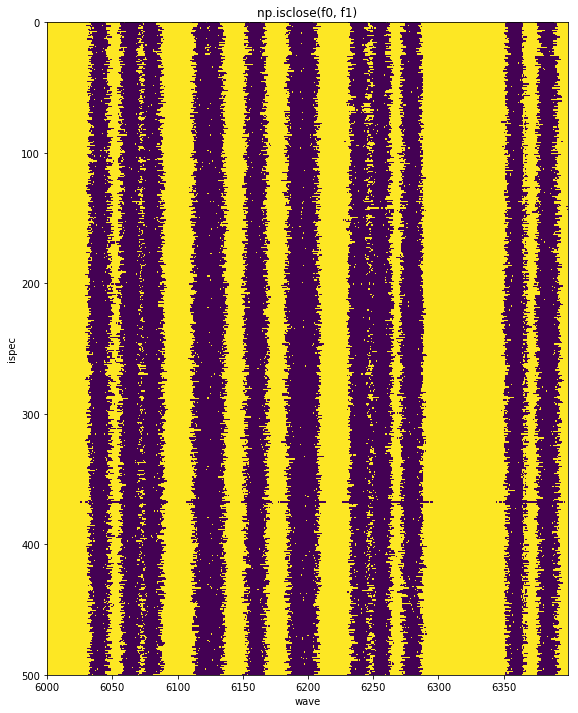

In [19]:
fig, ax = plt.subplots(figsize=(12, 12))
extent = [wmin, wmax, nspec, 0]
im = ax.imshow(
    isclose,
    extent=extent,
    interpolation='none',
)
# Draw red vertical lines at patch wavelength boundary
# ax.vlines(np.arange(wmin, wmax, 50*dw), 0, nspec, color='red', lw=3)
# ax.vlines(np.arange(wmin, wmax, 80*dw), 0, nspec, color='blue', lw=3)

ax.set_ylabel('ispec')
ax.set_xlabel('wave')
ax.set_title('np.isclose(f0, f1)')
;

/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10


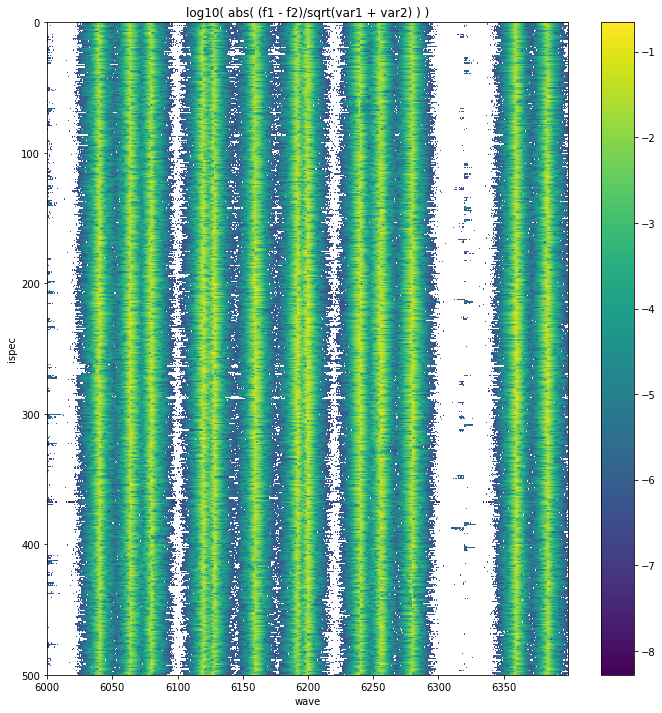

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
extent = [wmin, wmax, nspec, 0]
im = ax.imshow(
    np.log10(np.abs(diff)),
    extent=extent,
    interpolation='none',
)
# Draw red vertical lines at patch wavelength boundary
# ax.vlines(np.arange(wmin, wmax, 50*dw), 0, nspec, color='red', lw=3)
# ax.vlines(np.arange(wmin, wmax, 80*dw), 0, nspec, color='blue', lw=3, linestyles='dashed')

ax.set_ylabel('ispec')
ax.set_xlabel('wave')
ax.set_title('log10( abs( (f1 - f2)/sqrt(var1 + var2) ) )')
fig.colorbar(im, ax=ax)

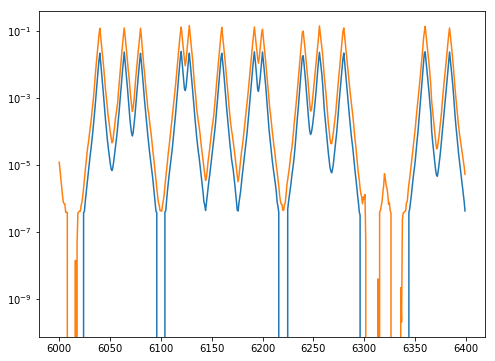

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(desi['wave'], np.percentile(np.abs(diff), 50, axis=0))
ax.plot(desi['wave'], np.percentile(np.abs(diff), 99, axis=0))
ax.set_yscale('log')